## Boston Housing Values
see details of the Kaggle competiton are at
https://www.kaggle.com/c/boston-housing/leaderboard



In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.datasets import load_boston
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, RandomizedLasso)
from sklearn.feature_selection import RFE, f_regression, SelectPercentile
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from minepy import MINE

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

boston = load_boston()

bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target
print(bos.head())


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


In [2]:
X = bos.drop('PRICE', axis = 1)
Y = bos['PRICE']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 5)

In [3]:
names = list(X)
 
ranks = {}
 
def rank_to_dict(ranks, names, order=1):
    # scale to 0:1 so that we can compare across models
    # coefficients are not comparable across models.
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))
 
# Principal Components Anlysis for Feature Selection 
# Want to use the first component which explains the largest variance
# Use the largest values. Negative values leave as zero
pca = PCA(n_components=3) 
fit = pca.fit(X) # summarize components 
pca_comp = fit.components_[0]
pca_comp[pca_comp<0] = 0 
# implies LSTAT, RM are the most important features

ranks["PCA"] = rank_to_dict(np.abs(pca_comp), names)


# implies LSTAT, PTRATIO are the most important features
    
# SelectPercentile provides an automatic procedure for keeping only a certain percentage of the best, 
# associated features. The available metrics for association are
# f_regression: Used only for numeric targets and based on linear regression performance.
# f_classif: Used only for categorical targets and based on the Analysis of Variance (ANOVA) statistical test.
# chi2: Performs the chi-square statistic for categorical targets, which is less sensible to the nonlinear 
#     relationship between the predictive variable and its target.
# F-Test checks for and only captures linear relationships between features and labels. A highly correlated 
# feature is given higher score and less correlated features are given lower score.
# Given that many different graphs can produce the same mean, variance, correlations
# Pearson correlation gives negative relationship

Selector_f = SelectPercentile(f_regression, percentile=25)
Selector_f.fit(X,Y)

f_scores = []
for name,score in zip(list(X),Selector_f.scores_):
    f_scores.append(score)
ranks["F_score"] = rank_to_dict(np.abs(f_scores), names)

    
# Maximal information coefficient
# Correlations between X and Y that can be used for linear or non-linear relationships
# Bins the data and returns range [0,1]
# note Pearson corr only detects linear relationships
m = MINE()

mic_scores=[]
for name in names:
    m.compute_score(X[name], Y)
    mic_scores.append(m.mic())
ranks["MIC"] = rank_to_dict(np.abs(mic_scores), names)
        
# Linear Regression 
lr = LinearRegression(normalize=True)
lr.fit(X, Y)
ranks["Linear reg"] = rank_to_dict(np.abs(lr.coef_), names)

# L2 Regularization
# force to small coefficients
ridge = Ridge(alpha=7)
ridge.fit(X, Y)
ranks["Ridge"] = rank_to_dict(np.abs(ridge.coef_), names)

# L1 Regularization
# force coefficients to 0
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = rank_to_dict(np.abs(lasso.coef_), names)
 
# Stability Selection
# idea is to apply a feature selection algorithm on different subsets of data and with different subsets of features
# resampling the train data and computing a Lasso on each resampling
# biased towards preferring variables with more categories
# For correlated features, the first is used, then second significantly dropped in importance 
# as impurity has been removed. 
# Sklearn implements stability selection in the randomized lasso and randomized logistics regression classes.
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["Stability"] = rank_to_dict(np.abs(rlasso.scores_), names)


# Recursive Feature Elimination with Linear Regression
# stop the search when 5 features are left (they will get equal scores)
rfe = RFE(lr, n_features_to_select=5)
rfe.fit(X,Y)
ranks["RFE"] = rank_to_dict(np.array(list(map(float, rfe.ranking_))), names, order=-1) 

# Random Forest
rf = RandomForestRegressor()
rf.fit(X,Y)
ranks["RF"] = rank_to_dict(rf.feature_importances_, names)


r = {}
for name in names:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in names:
    print( "%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))
    
    
# 'RM', 'LSTAT', 'PTRATIO' used in example
# I think we should use
# RM, LSTAT, NOX, PRATIO

	F_score	Lasso	Linear reg	MIC	PCA	RF	RFE	Ridge	Stability	Mean
CRIM	0.12	0.02	0.01	0.46	0.03	0.08	0.62	0.02	0.32	0.19
ZN	0.1	0.01	0.0	0.32	0.0	0.0	0.38	0.01	0.04	0.1
INDUS	0.24	0.01	0.0	0.58	0.03	0.01	0.5	0.01	0.2	0.18
CHAS	0.0	0.46	0.15	0.0	0.0	0.0	1.0	0.56	0.32	0.28
NOX	0.16	0.28	1.0	0.64	0.0	0.04	1.0	0.85	0.14	0.46
RM	0.78	1.0	0.21	0.66	0.0	0.81	1.0	1.0	1.0	0.72
AGE	0.12	0.0	0.0	0.6	0.09	0.02	0.0	0.0	0.04	0.1
DIS	0.03	0.31	0.08	0.38	0.0	0.13	1.0	0.33	0.0	0.25
RAD	0.12	0.07	0.02	0.3	0.05	0.0	0.75	0.07	0.04	0.16
TAX	0.21	0.0	0.0	0.4	1.0	0.05	0.25	0.0	0.4	0.26
PTRATIO	0.27	0.2	0.05	0.49	0.01	0.04	1.0	0.21	1.0	0.36
B	0.08	0.0	0.0	0.29	0.0	0.03	0.12	0.0	0.46	0.11
LSTAT	1.0	0.14	0.03	1.0	0.02	1.0	0.88	0.14	1.0	0.58


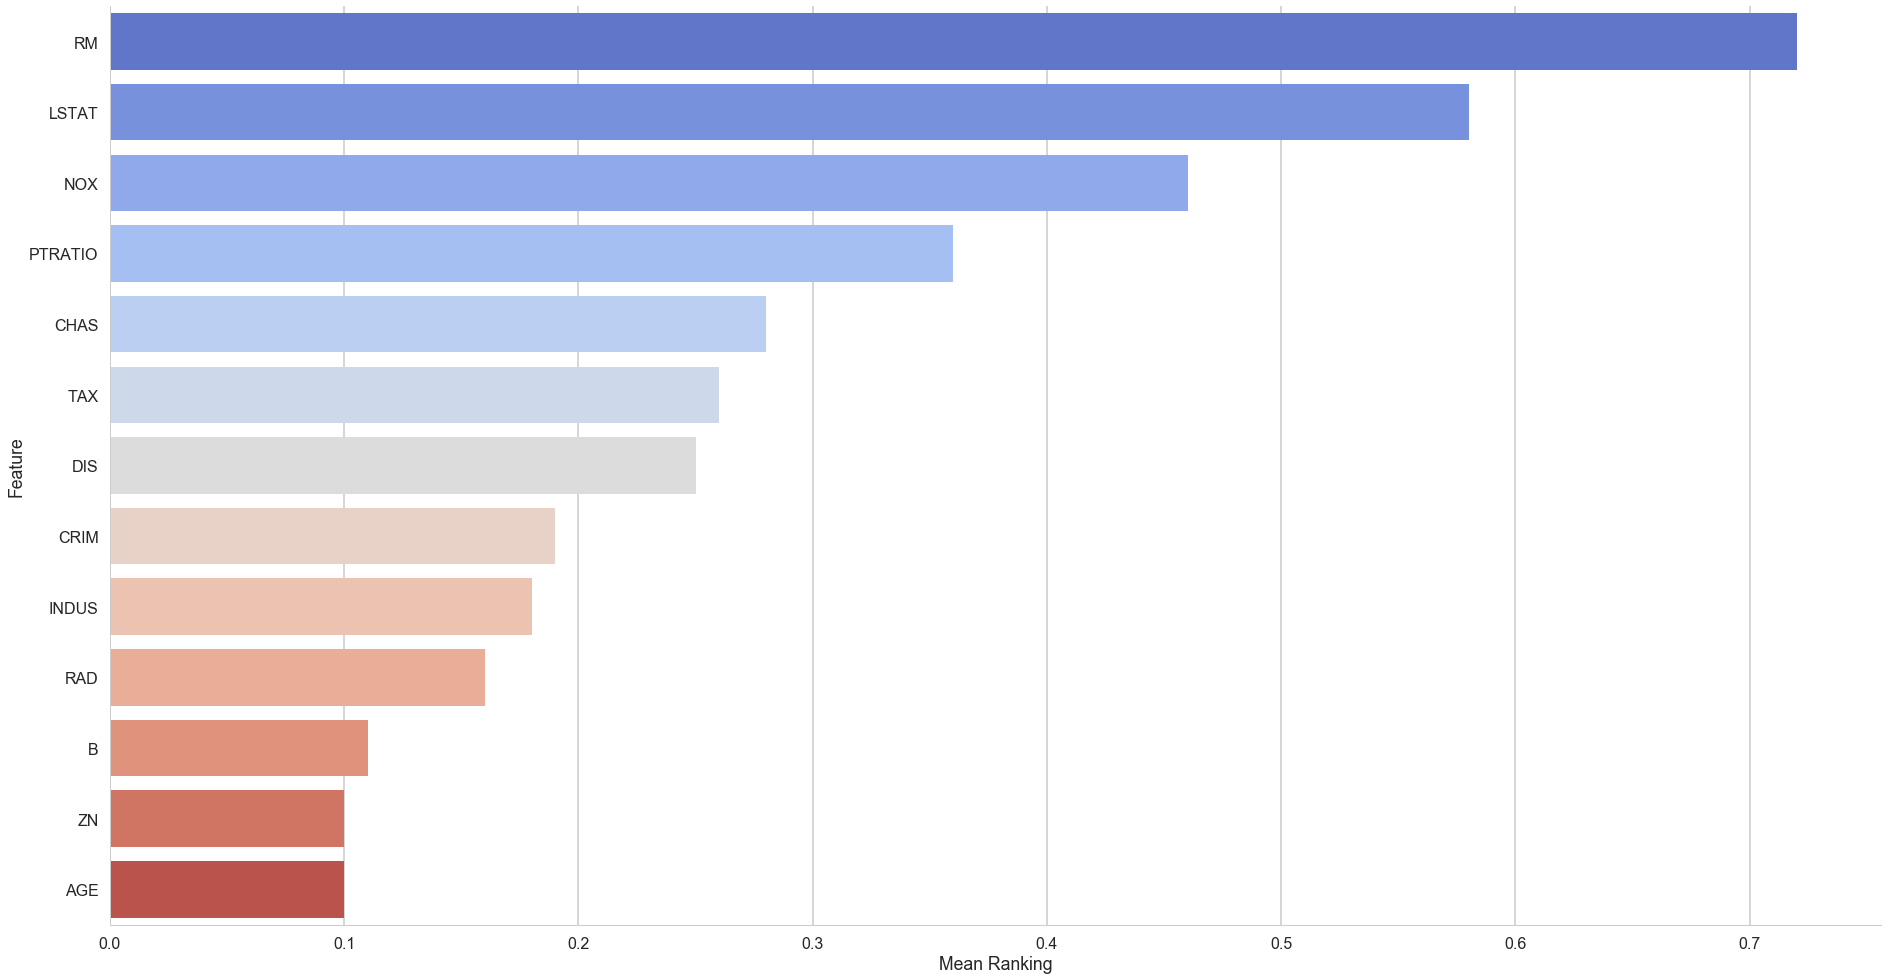

In [4]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(ranks["Mean"].items()))
meanplot.columns = ['Feature','Mean Ranking']

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')


In [5]:
# Final Conclusion
# use RM LSAT, NOX, PTRATIO
# ie. drop CHAS, DIS, CRIM, INDUS, RAD, TAX, B, ZN, AGE
# CHAS is a 0 or 1 categorical variable, so not sure I want to include at this point